In [1]:
from tqdm import tqdm
# from __future__ import print_function
# from __future__ import division
import torch
import pathlib2
from pathlib2 import Path
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from src import constant
# from robustbench import load_model
from src.utils import get_model
import time
import glob
import os
import matplotlib.pyplot as plt
import copy
from src.bootstrap import Cifar10Bootstrapper
from src.job import Cifar10Job
from src.utils import get_transformation_threshold, transform_image, transform_image_dir
import cv2
from src.dataset import GeneralDataset, GeneralDatasetAlter
from src.utils import start_matlab
import seaborn as sns
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.multiprocessing.set_sharing_strategy('file_system')

PyTorch Version:  1.9.0
Torchvision Version:  0.10.0


In [2]:
%matplotlib inline

In [3]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "Hendrycks2020AugMix_WRN"
num_classes = 10
train_dataset_path = "./transformed_data/train"
val_dataset_path = "./transformed_data/val"
batch_size = 8
num_epochs = 10
feature_extract = False

In [4]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    model.eval()
    print(device)
    model.to(device)
    avg_loss, avg_acc, _ = eval_model(dataloaders['val'], model, criterion, device)
    print(f"initial performance: avg_loss: {avg_loss}, avg_acc: {avg_acc}")
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss = {'train': [], 'val': []}
    acc = {'train': [], 'val': []}
    performance_records = []
    result_records = []
    pbar = tqdm(total=num_epochs)
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, IQA_scores, filepaths in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # record correctness for each image and their IQA values
                corrects = preds == labels.data
                for k in range(len(corrects)):
                    result_records.append({
                        'filepath': str(filepaths[k]),
                        'is_correct': bool(corrects[k]),
                        'label': int(labels.data[k]),
                        'phase': phase,
                        'epoch': epoch,
                        'pred': int(preds[k]),
                        'IQA_score': float(IQA_scores[k])
                    })

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            pbar.set_postfix({'epoch': epoch,'phase': phase,'loss': epoch_loss, 'accuracy': float(epoch_acc)})
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # loss[phase].append(epoch_loss)
            # acc[phase].append(epoch_acc)
            performance_records.append({
                'epoch': epoch,
                'value': float(epoch_loss),
                'type': 'loss', 
                'phase': phase
            })
            performance_records.append({
                'epoch': epoch,
                'value': float(epoch_acc),
                'type': 'acc', 
                'phase': phase
            })
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        pbar.update()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # plot
    # sns.lineplot(x="epoch", y="value",
    #          hue="type", style="phase",
    #          data=pd.DataFrame(data=performance_records))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, performance_records, result_records

In [5]:
def eval_model(dataloader, model, criterion, device):
    model.eval()
    running_loss = 0
    running_corrects = 0
    result_records = []
    for inputs, labels, IQA_scores, filepaths in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        corrects = preds == labels.data
        for k in range(len(filepaths)):
            result_records.append({
                'filepath': str(filepaths[k]),
                'is_correct': bool(corrects[k]),
                'label': int(labels.data[k]),
                'pred': int(preds[k]),
                'IQA_score': float(IQA_scores[k])
            })
    avg_loss = running_loss / len(dataloader.dataset)
    avg_acc = running_corrects.double() / len(dataloader.dataset)
    return float(avg_loss), float(avg_acc), pd.DataFrame(data=result_records)

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
performance_results = []

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

# image_datasets = {
#     'train': GeneralDataset(pathlib2.Path("./transformed_data/train")),
#     'val': GeneralDataset(pathlib2.Path("./transformed_data/val"))
# }

image_datasets = {
    'train': GeneralDatasetAlter(Path("./transformed_data/train"), Path("./data/cifar10_pytorch/train"), 0.5),
    'val': GeneralDatasetAlter(Path("./transformed_data/val"), Path("./data/cifar10_pytorch/val"), 0.5)
}


# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = get_model(model_name)
set_parameter_requires_grad(model_ft, feature_extract)
model_ft = model_ft.to(device)

In [9]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 block1.layer.0.bn1.weight
	 block1.layer.0.bn1.bias
	 block1.layer.0.conv1.weight
	 block1.layer.0.bn2.weight
	 block1.layer.0.bn2.bias
	 block1.layer.0.conv2.weight
	 block1.layer.0.convShortcut.weight
	 block1.layer.1.bn1.weight
	 block1.layer.1.bn1.bias
	 block1.layer.1.conv1.weight
	 block1.layer.1.bn2.weight
	 block1.layer.1.bn2.bias
	 block1.layer.1.conv2.weight
	 block1.layer.2.bn1.weight
	 block1.layer.2.bn1.bias
	 block1.layer.2.conv1.weight
	 block1.layer.2.bn2.weight
	 block1.layer.2.bn2.bias
	 block1.layer.2.conv2.weight
	 block1.layer.3.bn1.weight
	 block1.layer.3.bn1.bias
	 block1.layer.3.conv1.weight
	 block1.layer.3.bn2.weight
	 block1.layer.3.bn2.bias
	 block1.layer.3.conv2.weight
	 block1.layer.4.bn1.weight
	 block1.layer.4.bn1.bias
	 block1.layer.4.conv1.weight
	 block1.layer.4.bn2.weight
	 block1.layer.4.bn2.bias
	 block1.layer.4.conv2.weight
	 block1.layer.5.bn1.weight
	 block1.layer.5.bn1.bias
	 block1.layer.5.conv1.weight
	 block

In [10]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist, performance_records, result_records = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, device, num_epochs=num_epochs)

  0%|          | 0/1250 [00:00<?, ?it/s]

cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

initial performance: avg_loss: 0.6180593113836832, avg_acc: 0.8261000000000001


100%|██████████| 10/10 [14:49<00:00, 89.10s/it, epoch=9, phase=val, loss=0.326, accuracy=0.911]

Training complete in 14m 49s
Best val Acc: 0.917000


# Training Performance

In [11]:
trained_performance_df = pd.DataFrame(performance_records)
trained_performance_df

,epoch,value,type,phase
0,0,0.335308,loss,train
1,0,0.893720,acc,train
2,0,0.277223,loss,val
3,0,0.907100,acc,val
4,1,0.219993,loss,train
5,1,0.929820,acc,train
6,1,0.278503,loss,val
7,1,0.907100,acc,val
8,2,0.169039,loss,train
9,2,0.945640,acc,train


# Training Progress

<AxesSubplot:xlabel='epoch', ylabel='value'>

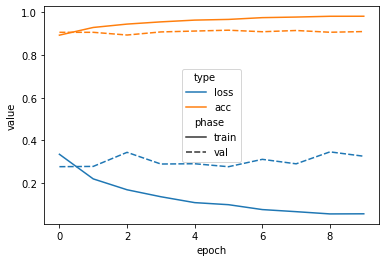

In [12]:
sns.lineplot(x="epoch", y="value", style='phase', hue='type', data=trained_performance_df)

# Training Records

In [13]:
result_df = pd.DataFrame(data=result_records)
result_df

,filepath,is_correct,label,phase,epoch,pred,IQA_score
0,transformed_data/train/contrast_24460.png,False,3,train,0,8,0.751969
1,transformed_data/train/contrast_49805.png,True,4,train,0,4,0.405192
2,transformed_data/train/contrast_11847.png,False,5,train,0,7,0.875324
3,transformed_data/train/contrast_24169.png,True,0,train,0,0,0.428728
4,transformed_data/train/contrast_22950.png,True,9,train,0,9,0.165810
...,...,...,...,...,...,...,...
599995,transformed_data/val/contrast_7517.png,True,2,val,9,2,0.319892
599996,transformed_data/val/contrast_3387.png,False,3,val,9,5,0.674893
599997,transformed_data/val/contrast_4170.png,True,1,val,9,1,0.642089
599998,transformed_data/val/contrast_4424.png,True,1,val,9,1,0.389897


# IQA Analysis

In [14]:
df1 = result_df[result_df['phase']=='val'].sort_values(by=['IQA_score'])
df1['IQA_interval'] = round(df1['IQA_score'], 1)
df1

,filepath,is_correct,label,phase,epoch,pred,IQA_score,IQA_interval
476446,transformed_data/val/contrast_6335.png,True,2,val,7,2,0.110267,0.1
415247,transformed_data/val/contrast_6335.png,True,2,val,6,2,0.110267,0.1
535368,transformed_data/val/contrast_6335.png,True,2,val,8,2,0.110267,0.1
593421,transformed_data/val/contrast_6335.png,True,2,val,9,2,0.110267,0.1
235588,transformed_data/val/contrast_6335.png,True,2,val,3,2,0.110267,0.1
...,...,...,...,...,...,...,...,...
471246,transformed_data/val/contrast_1385.png,True,5,val,7,5,0.950092,1.0
292586,transformed_data/val/contrast_1385.png,True,5,val,4,5,0.950092,1.0
413090,transformed_data/val/contrast_1385.png,True,5,val,6,5,0.950092,1.0
350576,transformed_data/val/contrast_1385.png,True,5,val,5,5,0.950092,1.0


In [15]:
df1.groupby(by=["IQA_interval"]).sum()

,is_correct,label,epoch,pred,IQA_score
IQA_interval,,,,,
0.1,2234,11670,11925,11602,346.489215
0.2,5423,27320,27405,27146,1226.389501
0.3,7250,36330,36450,36331,2441.512392
0.4,8899,44650,44010,44557,3926.400404
0.5,11163,54300,54900,54162,6118.266359
0.6,14639,71520,71820,71244,9589.170651
0.7,18082,89500,89415,90192,13926.395489
0.8,17282,85330,85050,85265,15074.193927
0.9,5927,29330,28980,29228,5672.726464


In [16]:
trained_IQA_int_dist_df = df1[df1['epoch']==df1['epoch'].max()].groupby(by=["IQA_interval"]).sum()[['is_correct']]
trained_IQA_int_dist_df

,is_correct
IQA_interval,
0.1,223
0.2,543
0.3,733
0.4,895
0.5,1116
0.6,1471
0.7,1799
0.8,1731
0.9,594


# Finetuned Model + Transformed Dataset

In [17]:
avg_loss, avg_acc, _ = eval_model(dataloaders_dict['val'], model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'original', 'dataset': 'original', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 1250/1250 [00:06<00:00, 184.90it/s]

avg_loss: 0.2770988136266358, avg_acc: 0.917


# Original Model + Transformed Dataset (val)

In [18]:
original_model_ft = get_model(model_name)
original_model_ft = original_model_ft.to(device)
original_model_ft.eval()
# evaluate
avg_loss, avg_acc, records_df = eval_model(dataloaders_dict['val'], original_model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'original', 'dataset': 'transformed', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 1250/1250 [00:06<00:00, 180.60it/s]

avg_loss: 0.6180593127981759, avg_acc: 0.8261000000000001


In [19]:
records_df['IQA_interval'] = round(records_df['IQA_score'], 1)
records_df

,filepath,is_correct,label,pred,IQA_score,IQA_interval
0,transformed_data/val/contrast_3977.png,True,3,3,0.442454,0.4
1,transformed_data/val/contrast_2386.png,False,4,5,0.568196,0.6
2,transformed_data/val/contrast_5445.png,True,7,7,0.869608,0.9
3,transformed_data/val/contrast_6969.png,True,2,2,0.781758,0.8
4,transformed_data/val/contrast_9666.png,True,3,3,0.783179,0.8
...,...,...,...,...,...,...
9995,transformed_data/val/contrast_787.png,True,9,9,0.739346,0.7
9996,transformed_data/val/contrast_3920.png,True,7,7,0.697746,0.7
9997,transformed_data/val/contrast_3679.png,True,0,0,0.671125,0.7
9998,transformed_data/val/contrast_6423.png,False,5,4,0.669337,0.7


In [20]:
records_df.sort_values(by=['IQA_score']).groupby(by=['IQA_interval']).sum()
orig_IQA_interval_dist_df = records_df.sort_values(by=['IQA_score']).groupby(by=['IQA_interval']).sum()[['is_correct']]
orig_IQA_interval_dist_df

,is_correct
IQA_interval,
0.1,93
0.2,332
0.3,583
0.4,795
0.5,1031
0.6,1375
0.7,1771
0.8,1688
0.9,592


array([[<AxesSubplot:title={'center':'is_correct'}>]], dtype=object)

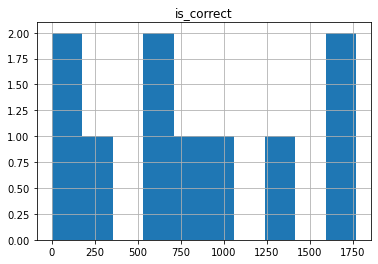

In [21]:
orig_IQA_interval_dist_df.hist()

array([[<AxesSubplot:title={'center':'is_correct'}>]], dtype=object)

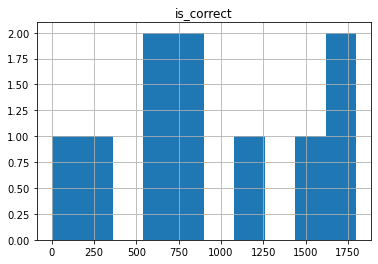

In [22]:
trained_IQA_int_dist_df.hist()

In [23]:
orig_IQA_interval_dist_df['type'] = 'original'
trained_IQA_int_dist_df['type'] = 'trained'
orig_IQA_interval_dist_df.reset_index(inplace=True)
trained_IQA_int_dist_df.reset_index(inplace=True)

100%|██████████| 10/10 [15:04<00:00, 90.49s/it, epoch=9, phase=val, loss=0.326, accuracy=0.911]


<AxesSubplot:xlabel='IQA_interval', ylabel='is_correct'>

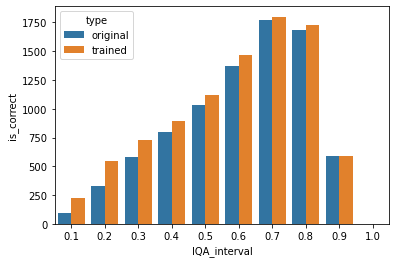

In [24]:
sns.barplot(x="IQA_interval", y="is_correct", hue="type", data=pd.concat([orig_IQA_interval_dist_df, trained_IQA_int_dist_df]))

In [25]:
df = records_df.sort_values(by=['IQA_score'])
df.groupby(by='IQA_interval').count()

,filepath,is_correct,label,pred,IQA_score
IQA_interval,,,,,
0.1,265,265,265,265,265
0.2,609,609,609,609,609
0.3,810,810,810,810,810
0.4,978,978,978,978,978
0.5,1220,1220,1220,1220,1220
0.6,1596,1596,1596,1596,1596
0.7,1987,1987,1987,1987,1987
0.8,1890,1890,1890,1890,1890
0.9,644,644,644,644,644


In [26]:
df1[df1['epoch']==df1['epoch'].max()].groupby(by=["IQA_interval"]).count()

,filepath,is_correct,label,phase,epoch,pred,IQA_score
IQA_interval,,,,,,,
0.1,265,265,265,265,265,265,265
0.2,609,609,609,609,609,609,609
0.3,810,810,810,810,810,810,810
0.4,978,978,978,978,978,978,978
0.5,1220,1220,1220,1220,1220,1220,1220
0.6,1596,1596,1596,1596,1596,1596,1596
0.7,1987,1987,1987,1987,1987,1987,1987
0.8,1890,1890,1890,1890,1890,1890,1890
0.9,644,644,644,644,644,644,644


In [27]:
orig_IQA_interval_dist_df['is_correct'].sum()

8261

In [28]:
trained_IQA_int_dist_df['is_correct'].sum()

9106

# Original Model on Original Dataset

In [29]:
original_dataset = GeneralDataset(pathlib2.Path("./data/cifar10_pytorch/val"))
original_dataloader = torch.utils.data.DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [30]:
avg_loss, avg_acc, _ = eval_model(original_dataloader, original_model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'original', 'dataset': 'original', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 1250/1250 [00:06<00:00, 185.38it/s]

avg_loss: 0.15373984944529365, avg_acc: 0.9508000000000001


# New Model on Original Dataset

In [31]:
avg_loss, avg_acc, _ = eval_model(original_dataloader, model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'finetuned', 'dataset': 'original', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 1250/1250 [00:06<00:00, 187.42it/s]

avg_loss: 0.4710171688494738, avg_acc: 0.8678


# Transformed Model on Cifar10C

In [32]:
cifar10c_dataset = GeneralDataset(pathlib2.Path("./data/cifar-10-c-images/contrast"))
cifar10c_dataloader = torch.utils.data.DataLoader(cifar10c_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [33]:
avg_loss, avg_acc, _ = eval_model(cifar10c_dataloader, model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'finetuned', 'dataset': 'cifar10c', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 6250/6250 [00:32<00:00, 191.30it/s]

avg_loss: 0.27402268285757164, avg_acc: 0.9183600000000001


# Original Model on Cifar10C

In [34]:
avg_loss, avg_acc, _ = eval_model(cifar10c_dataloader, original_model_ft, criterion, device)
print(f"avg_loss: {avg_loss}, avg_acc: {avg_acc}")
performance_results.append({'model': 'original', 'dataset': 'cifar10c', 'accuracy': avg_acc, 'loss': avg_loss})

100%|██████████| 6250/6250 [00:32<00:00, 190.76it/s]


avg_loss: 0.589466343575092, avg_acc: 0.83194


In [35]:
final_result_df = pd.DataFrame(data=performance_results)
final_result_df

,model,dataset,accuracy,loss
0,original,original,0.91700,0.277099
1,original,transformed,0.82610,0.618059
2,original,original,0.95080,0.153740
3,finetuned,original,0.86780,0.471017
4,finetuned,cifar10c,0.91836,0.274023
5,original,cifar10c,0.83194,0.589466
